In [2]:
from training import (
    load_data,
    prepare_data,
    split_data,
    train_model,
    preprocess_data,
)
from best_pipeline import best_pipeline_intown
from sklearn.model_selection import GridSearchCV

path = "../data/music_picks/model_statistics.csv"
df = load_data(path)
df = prepare_data(df)
X_train, X_test, y_train, y_test = split_data(df)
X_train, X_test = preprocess_data(X_train, X_test)

Shape of loaded data: (5806, 37)
Shape after dropping columns: (5806, 27)
Shape after handling null values: (5806, 27)
Shape of training data: (4644, 26)
Shape of training data after preprocessing: (4644, 153)


In [6]:
# Define the parameters for the model
params_grid = dict(
    model__max_iter=[500, 1000, 1500],
    model__learning_rate=[0.1, 0.01, 0.001],
    model__max_depth =[25, 50, 75, None],
    model__l2_regularization=[0.1, 0.01, 0.001],
    model__scoring=['accuracy'],
    anova__k=X_train.shape[1],
)


pipeline = train_model(X_train, y_train, params_grid)
print(pipeline.score(X_test, y_test))


0.6436884512085944


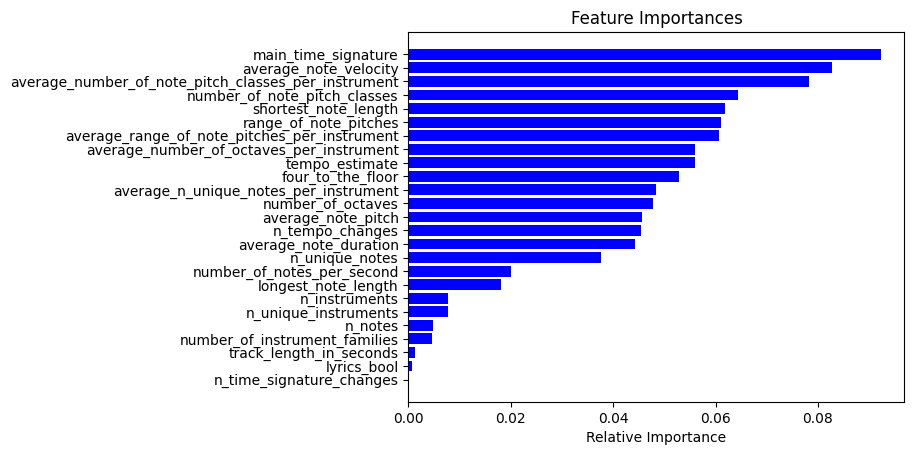

In [15]:
# plot feature importance
import matplotlib.pyplot as plt
import numpy as np

features = X_train.columns
importances = pipeline['model'].feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [3]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# hyperparameter tuning
# Create the parameter grid based on the results of random search
params_grid = dict(
    model__max_iter=[1000],
    model__learning_rate=[0.01, 0.005, 0.001],
    model__max_depth =[None],
    model__l2_regularization=[0., 0.0001, 0.00001],
    model__scoring=['accuracy'],
    anova__k=[X_train.shape[1]],
)

# Instantiate pipeline
pipeline = best_pipeline_intown(X_train)

# Instantiate the grid search model
grid_search = HalvingGridSearchCV(estimator = pipeline, param_grid=params_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 516
max_resources_: 4644
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 516
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 1548
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 1
n_resources: 4644
Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'anova__k': 153,
 'model__l2_regularization': 0.0,
 'model__learning_rate': 0.01,
 'model__max_depth': None,
 'model__max_iter': 1000,
 'model__scoring': 'accuracy'}

In [16]:
from sklearn_evaluation import plot

# see top 10 results
grid_search.cv_results_

import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)

In [18]:
# export results
results.to_csv('grid_search_results.csv', index=False)